# WUT? - A Wrapper for Uncertainty in Tensorflow

Hello, Welcome to the Internal Guide to this Uncertainy Library-- This python notebook should contain everything a man needs to use and alter this package as he sees fit.

Now we're gonna make two models, very simple bois for regression and classification, respectively. IMPORTANT NOTE that in these networks, the output to the call is the output of the last Dense Layer. This is the only requirement for this package to work with your models. (Ensembles and Dropout should work for anything, though)

Disclaimer: In this guide, we only want to show how to use the WUT? library. **Please do not compare model performance by merely looking at the plots below** as they are trained differently. Different methods require different number of training epochs and other configurations to achieve the best results. Each method has its own advantages and disadvantages that we do not discuss in this guide.

# **1. Regression**

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import tensorflow as tf
import WUT as WUT

Let's define some plotting functions for future use.

In [2]:
def plot1d_meanvar(X, Y, Xq, Yq, sigma=None, ylims=[-1.5, 1.5]):
    pl.figure()
    pl.scatter(X, Y, c = 'k', s = 1, label = 'data')
    if Yq is not None:
        pl.plot(Xq, Yq[:,0,:], c = 'b', label = 'predicted mean')
    if sigma is not None:
        pl.fill_between(Xreg1q.squeeze(), Yq - 2*sigma, Yq + 2*sigma, alpha = 0.2, label = 'predicted SD')
        pl.ylim(ylims)
    pl.legend()
    
def plot1d_samples(X, Y, Xq, Ys, ylims=[-1.5, 1.5]):
    pl.figure()
    pl.scatter(X, Y, c = 'k', s = 1, label = 'data')
    for i in range(Yreg1s.shape[0]):
        pl.plot(Xq, Ys[i,:,:], c = 'b', alpha = 0.3, label = 'prediction {}'.format(i))
    pl.ylim(ylims)
    pl.legend()

Let's create a dataset.

X query/predict shapes: (1000, 1)
X-Y train shapes: (10000, 1) (10000, 1)
X-Y test shapes: (1000, 1) (1000, 1)


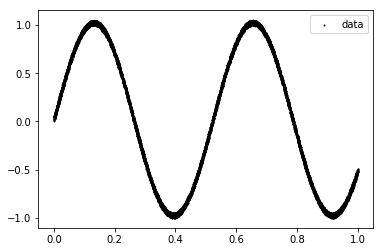

In [3]:
# Groundtruth function
def groundtruth1(X):
    return np.sin(12*X)

# Query dataset for prediction
Nq = 1000
Xreg1q = np.linspace(-0.2, 1.2, Nq)[:,None]
print("X query/predict shapes:", Xreg1q.shape)



# Training dataset
N = 10000
Xreg1 = np.random.random((N,1))
Yreg1 = groundtruth1(Xreg1) + 0.05*np.random.random((N,1))
print("X-Y train shapes:", Xreg1.shape, Yreg1.shape)
ylims = [-1.5,1.5] # This will be used for plotting
plot1d_meanvar(Xreg1, Yreg1, Xreg1q, None, None, ylims)


# Test dataset for evaluation
Xreg1t = Xreg1q
Yreg1t = groundtruth1(Xreg1q)
print("X-Y test shapes:", Xreg1t.shape, Yreg1t.shape)

Let's define our network. 

In [4]:
class RegModel1(tf.keras.Model):

    def __init__(self):
        super(RegModel1, self).__init__()
        self.dense1 = tf.keras.layers.Dense(8, activation = tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(64, activation = tf.nn.relu)
        self.dense3 = tf.keras.layers.Dense(64, activation = tf.nn.relu)
        self.dense4 = tf.keras.layers.Dense(1)

    def call(self, inputs, training = False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.dense4(x)

# 1.1 Deterministic Inference

Let us train the neural network as we usually do. We will only get a deterministic estimate. Sorry, no uncertainty bounds!

In [6]:
# Train
regmodel1 = RegModel1()
regmodel1.compile(optimizer = tf.keras.optimizers.SGD(), loss = tf.keras.losses.MSE)
regmodel1.fit(Xreg1, Yreg1, epochs = 30, batch_size = 20)

Epoch 1/30
500/500 [==============================] - 0s 587us/step - loss: 0.4687
Epoch 2/30
500/500 [==============================] - 0s 572us/step - loss: 0.4409
Epoch 3/30
500/500 [==============================] - 0s 608us/step - loss: 0.4379
Epoch 4/30
500/500 [==============================] - 0s 543us/step - loss: 0.4345
Epoch 5/30
500/500 [==============================] - 0s 574us/step - loss: 0.4292
Epoch 6/30
500/500 [==============================] - 0s 582us/step - loss: 0.4232
Epoch 7/30
500/500 [==============================] - 0s 597us/step - loss: 0.4146
Epoch 8/30
500/500 [==============================] - 0s 588us/step - loss: 0.4055
Epoch 9/30
500/500 [==============================] - 0s 589us/step - loss: 0.3948
Epoch 10/30
500/500 [==============================] - 0s 566us/step - loss: 0.3821
Epoch 11/30
500/500 [==============================] - 0s 572us/step - loss: 0.3681
Epoch 12/30
500/500 [==============================] - 0s 590us/step - loss: 0.3478
E

X-Y predict shapes: (1000, 1) (1000, 1)
313/313 [==============================] - 0s 659us/step - loss: 0.0362
Evaluate train: 0.036239027976989746
32/32 [==============================] - 0s 800us/step - loss: 1.2017
Evaluate test: 1.2017232179641724


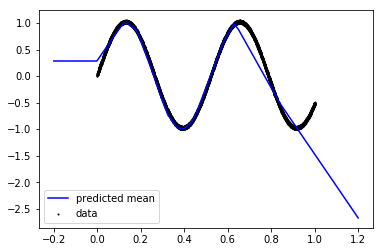

In [7]:
# Predict
Yreg1q = regmodel1.predict(Xreg1q)
print("X-Y predict shapes:", Xreg1q.shape, Yreg1q.shape)
plot1d_meanvar(Xreg1, Yreg1, Xreg1q, tf.expand_dims(Yreg1q,2), None, ylims)

# Evaluate
print("Evaluate train:", regmodel1.evaluate(Xreg1, Yreg1))
print("Evaluate test:", regmodel1.evaluate(Xreg1t, Yreg1t))

# 1.2. Ensemble of Networks

An ensemble of neural networks is simply a collection of neural networks trained seperately. Since each network will be trained slightly differently, capturing the epistemic uncertainty, the outputs for a given test input will be different as well. We can compute the mean and standard deviation (SD) for each test input from these outputs. 

In [ ]:
from WUT.Ensemble import Ensemble 

# Model
Nen = 3 # Number of networks for the ensemble
regmodel1en = Ensemble(RegModel1, Nen) # The only thing we need to do is simply wrapping our Keras model inside WUT.Ensemble()

# Train
regmodel1en.compile(optimizer = tf.keras.optimizers.SGD(), loss = tf.keras.losses.MSE)
regmodel1en.fit(Xreg1, Yreg1, epochs = 30, batch_size = 20)

Epoch 1/30
Epoch 1/30Epoch 1/30

500/500 [==============================] - 1s 2ms/step - loss: 0.5005
Epoch 2/30
500/500 [==============================] - 1s 2ms/step - loss: 0.4815
Epoch 2/30
500/500 [==============================] - 1s 2ms/step - loss: 0.4519
Epoch 3/30
500/500 [==============================] - 1s 2ms/step - loss: 0.4381
Epoch 3/30
500/500 [==============================] - 1s 2ms/step - loss: 0.4378
Epoch 3/30
500/500 [==============================] - 1s 2ms/step - loss: 0.4336
Epoch 4/30
500/500 [==============================] - 1s 2ms/step - loss: 0.4160
Epoch 4/30
500/500 [==============================] - 1s 2ms/step - loss: 0.4371
Epoch 5/30
500/500 [==============================] - 1s 2ms/step - loss: 0.4299
Epoch 5/30
500/500 [==============================] - 1s 2ms/step - loss: 0.435900 [======================>.......] - ETA: 0s - lo
Epoch 6/30
500/500 [==============================] - 1s 2ms/step - loss: 0.3882
Epoch 6/30
500/500 [=================

In [ ]:
# Predict
Yreg1q = regmodel1en.predict(Xreg1q) # The mean and sd are the 0th and 1st columns, respectively
mean, sd = tf.reshape(Yreg1q[:,0,:],[-1]), tf.reshape(Yreg1q[:,1,:],[-1])

print("Xq-Yq shapes:", Xreg1q.shape, Yreg1q.shape)
print("Eval:", regmodel1en.evaluate(Xreg1, Yreg1))
print("Eval_q:", regmodel1en.evaluate(Xreg1q, Yreg1q))

pl.scatter(Xreg1, Yreg1, c = 'k', s = 1, label = 'data')
pl.plot(Xreg1q, Yreg1q[:,0,:], c = 'b', label = 'predicted mean')
pl.fill_between(Xreg1q.squeeze(), mean - 2*sd, mean + 2*sd, alpha = 0.2, label = 'predicted SD')
pl.ylim([-1.5, 1.5])
pl.legend()

Xq-Ys shapes: (1000, 1) (3, 1000, 1)


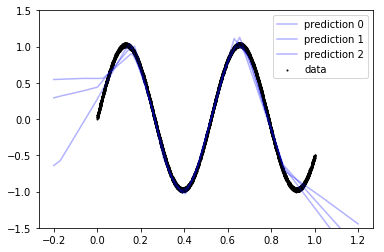

In [8]:
# Sample - rather than merely computing the meand and sd, we can also see what each neural network outputs
Yreg1s = regmodel1en.sample(Xreg1q)
print("Xq-Ys shapes:", Xreg1q.shape, Yreg1s.shape) # Each NN output is in the 0th column

pl.scatter(Xreg1, Yreg1, c = 'k', s = 1, label = 'data')
for i in range(Yreg1s.shape[0]):
    pl.plot(Xreg1q, Yreg1s[i,:,:], c = 'b', alpha = 0.3, label = 'prediction {}'.format(i))
pl.ylim([-1.5, 1.5])
pl.legend()

# 1.3. Monte Carlo Dropout

In [6]:
from WUT.Dropout import Dropout

# Model
rate = 0.2 # What rate to neurons drop out
regmodel1dp = Dropout(RegModel1, rate = 0.2, dropout_layers = [tf.keras.layers.Dense])

# Train
regmodel1dp.compile(optimizer = tf.keras.optimizers.SGD(), loss = tf.keras.losses.MSE)
regmodel1dp.fit(Xreg1, Yreg1, epochs = 30, batch_size = 20)

Epoch 1/30
500/500 [==============================] - 0s 608us/step - loss: 0.5006
Epoch 2/30
500/500 [==============================] - 0s 555us/step - loss: 0.4754
Epoch 3/30
500/500 [==============================] - 0s 596us/step - loss: 0.4613
Epoch 4/30
500/500 [==============================] - 0s 553us/step - loss: 0.4622
Epoch 5/30
500/500 [==============================] - 0s 579us/step - loss: 0.4584
Epoch 6/30
500/500 [==============================] - 0s 571us/step - loss: 0.4512
Epoch 7/30
500/500 [==============================] - 0s 589us/step - loss: 0.4466
Epoch 8/30
500/500 [==============================] - 0s 552us/step - loss: 0.4436
Epoch 9/30
500/500 [==============================] - 0s 552us/step - loss: 0.4397
Epoch 10/30
500/500 [==============================] - 0s 553us/step - loss: 0.4284
Epoch 11/30
500/500 [==============================] - 0s 568us/step - loss: 0.4212
Epoch 12/30
500/500 [==============================] - 0s 759us/step - loss: 0.4119
E

Xq-Yq shapes: (1000, 1) (1000, 2, 1)
313/313 [==============================] - 0s 1ms/step - loss: 0.1871
Eval: [0.18656010925769806, 0.18711569905281067, 0.187077134847641]
32/32 [==============================] - 0s 3ms/step - loss: 0.4943
Eval_q: [0.38999566435813904, 0.4942944347858429, 0.46443745493888855]


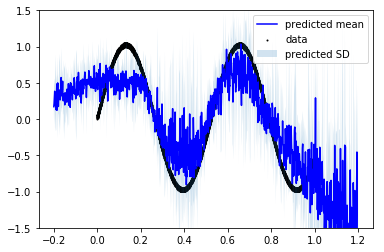

In [7]:
# Predict
Yreg1q = regmodel1dp.predict(Xreg1q)
print("Xq-Yq shapes:", Xreg1q.shape, Yreg1q.shape)
print("Eval:", regmodel1dp.evaluate(Xreg1, Yreg1))
print("Eval_q:", regmodel1dp.evaluate(Xreg1q, Yreg1q))

mean, sd = tf.reshape(Yreg1q[:,0,:],[-1]), tf.reshape(Yreg1q[:,1,:],[-1])

pl.scatter(Xreg1, Yreg1, c = 'k', s = 1, label = 'data')
pl.plot(Xreg1q, Yreg1q[:,0,:], c = 'b', label = 'predicted mean')
pl.fill_between(Xreg1q.squeeze(), mean - 2*sd, mean + 2*sd, alpha = 0.2, label = 'predicted SD')
pl.ylim([-1.5, 1.5])
pl.legend()

Xq-Ys shapes: (1000, 1) (3, 1000, 1)


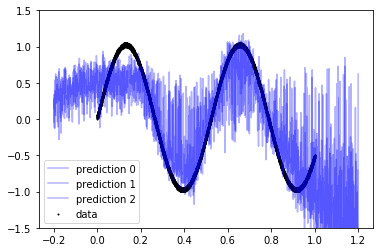

In [9]:
# Sample - rather than merely computing the meand and sd, we can also see what each neural network outputs
Yreg1s = regmodel1dp.sample(Xreg1q)
print("Xq-Ys shapes:", Xreg1q.shape, Yreg1s.shape) # Each NN output is in the 0th column

pl.scatter(Xreg1, Yreg1, c = 'k', s = 1, label = 'data')
for i in range(Yreg1s.shape[0]):
    pl.plot(Xreg1q, Yreg1s[i,:,:], c = 'b', alpha = 0.3, label = 'prediction {}'.format(i))
pl.ylim([-1.5, 1.5])
pl.legend()

# Variance Networks

In [ ]:
from WUT.Variance_Network import Variance_Network

# Model
regmodel1vn = Variance_Network(RegModel1)

# Train
regmodel1vn.compile(optimizer = tf.keras.optimizers.SGD(), loss = tf.keras.losses.MSE)
regmodel1vn.fit(Xreg1, Yreg1, epochs=20, batch_size=16)

Epoch 1/20
625/625 [==============================] - 1s 1ms/step - loss: 0.5111
Epoch 2/20
625/625 [==============================] - 1s 1ms/step - loss: 0.4295
Epoch 3/20
625/625 [==============================] - 1s 1ms/step - loss: 0.4202
Epoch 4/20
625/625 [==============================] - 1s 1ms/step - loss: 0.4129
Epoch 5/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3866
Epoch 6/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3740
Epoch 7/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3645
Epoch 8/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3562
Epoch 9/20
625/625 [==============================] - 1s 1ms/step - loss: 0.3276
Epoch 10/20
625/625 [==============================] - 1s 1ms/step - loss: 0.2955
Epoch 11/20
625/625 [==============================] - 1s 1ms/step - loss: 0.2299
Epoch 12/20
625/625 [==============================] - 1s 1ms/step - loss: 0.1535
Epoch 13/20
625/625 [====

Xq-Yq shapes: (1000, 1) (1000, 2, 1)
313/313 [==============================] - 0s 974us/step - loss: 0.0286
Eval: 0.028628064319491386
32/32 [==============================] - 0s 2ms/step - loss: 0.2546
Eval_q: 0.254580020904541


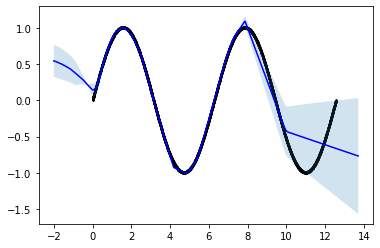

In [ ]:
# Predict
Nq = 1000
Xreg1q = np.linspace(0, 5*np.pi, Nq)[:,None] - 2
Yreg1q = regmodel1vn.predict(Xreg1q)
print("Xq-Yq shapes:", Xreg1q.shape, Yreg1q.shape)
print("Eval:", regmodel1vn.evaluate(Xreg1, Yreg1))
print("Eval_q:", regmodel1vn.evaluate(Xreg1q, Yreg1q))

pl.scatter(Xreg1, Yreg1, c='k', s=1)
pl.plot(Xreg1q, Yreg1q[:,0,:], c='b')
mean, sd = tf.reshape(Yreg1q[:,0,:],[-1]), tf.reshape(Yreg1q[:,1,:],[-1])
pl.fill_between(Xreg1q.squeeze(), mean - 2*sd, mean + 2*sd, alpha=0.2)

# Stochastic Variational Inference

In [ ]:
from WUT.SVI import SVI

# Model
regmodel1vi = SVI(RegModel1)

# Train
regmodel1vi.compile(optimizer = tf.keras.optimizers.Adam(lr=0.001)) #, loss = tf.keras.losses.MSE #Err Why vanilla SGD doesn't work? ERR: Becomes nan when the lr is too high
regmodel1vi.fit(tf.convert_to_tensor(Xreg1, dtype=tf.float32), tf.convert_to_tensor(Yreg1, dtype=tf.float32), epochs=20, batch_size=16) #Err had change the scale

Epoch 1/20
625/625 [==============================] - 4s 2ms/step - loss: 257054.7821
Epoch 2/20
625/625 [==============================] - 1s 2ms/step - loss: 107239.3916
Epoch 3/20
625/625 [==============================] - 1s 2ms/step - loss: 49911.9786
Epoch 4/20
625/625 [==============================] - 1s 2ms/step - loss: 38073.1846
Epoch 5/20
625/625 [==============================] - 1s 2ms/step - loss: 24221.6173
Epoch 6/20
625/625 [==============================] - 1s 2ms/step - loss: 14301.3439
Epoch 7/20
625/625 [==============================] - 1s 2ms/step - loss: 10716.6641
Epoch 8/20
625/625 [==============================] - 1s 2ms/step - loss: 9839.5773
Epoch 9/20
625/625 [==============================] - 1s 2ms/step - loss: 6081.5319
Epoch 10/20
625/625 [==============================] - 1s 2ms/step - loss: 4852.2515
Epoch 11/20
625/625 [==============================] - 1s 2ms/step - loss: 3034.7029
Epoch 12/20
625/625 [==============================] - 1s 2ms/ste

313/313 [==============================] - 0s 2ms/step - loss: 197686.3906
Eval: 197686.390625
32/32 [==============================] - 0s 1ms/step - loss: 218498.4688
Eval_q: 218498.46875


(-1.5, 1.5)

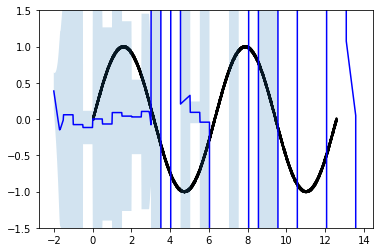

In [ ]:
# Predict
Nq = 1000
Xreg1q = np.linspace(0, 5*np.pi, Nq)[:,None] - 2
Yreg1q = regmodel1vi.predict(tf.convert_to_tensor(Xreg1q, dtype=tf.float32)) # ERR 4 
mean, sd = tf.reshape(Yreg1q.loc, [-1]), tf.reshape(Yreg1q.scale, [-1])
# print("Xq-Yq shapes:", Xreg1q.shape, Yreg1q.shape, mean.shape, sd.shape) 
print("Eval:", regmodel1vi.evaluate(Xreg1, Yreg1))
print("Eval_q:", regmodel1vi.evaluate(Xreg1q, mean)) 

pl.scatter(Xreg1, Yreg1, c='k', s=1)
pl.plot(Xreg1q, mean, c='b')
pl.fill_between(Xreg1q.squeeze(), mean - 2*sd, mean + 2*sd, alpha=0.2)
pl.ylim([-1.5, 1.5])

# Mxiture Density Networks

In [ ]:
from WUT.Gaussian_Mixtures import Gaussian_Mixtures

# Model
regmodel1gm = Gaussian_Mixtures(RegModel1, 5)

# Train
regmodel1gm.compile(optimizer = tf.keras.optimizers.SGD()) #, loss = tf.keras.losses.MSE  # # ERR 3 -show we have a loss?
regmodel1gm.fit(Xreg1, Yreg1, epochs=20, batch_size=16)

Epoch 1/20
625/625 [==============================] - 3s 2ms/step - loss: 1.0237
Epoch 2/20
625/625 [==============================] - 1s 2ms/step - loss: 0.8097
Epoch 3/20
625/625 [==============================] - 1s 2ms/step - loss: 0.7057
Epoch 4/20
625/625 [==============================] - 1s 2ms/step - loss: 0.6634
Epoch 5/20
625/625 [==============================] - 1s 2ms/step - loss: 0.6068
Epoch 6/20
625/625 [==============================] - 1s 2ms/step - loss: 0.5100
Epoch 7/20
625/625 [==============================] - 1s 2ms/step - loss: 0.4529
Epoch 8/20
625/625 [==============================] - 1s 2ms/step - loss: 0.4159
Epoch 9/20
625/625 [==============================] - 1s 2ms/step - loss: 0.3475
Epoch 10/20
625/625 [==============================] - 1s 2ms/step - loss: 0.3959
Epoch 11/20
625/625 [==============================] - 1s 2ms/step - loss: 0.3136
Epoch 12/20
625/625 [==============================] - 1s 2ms/step - loss: 0.3166
Epoch 13/20
625/625 [====

(100, 1000, 1)
Xq-Yq shapes: (1000, 1) (100, 1000, 1)
313/313 [==============================] - 0s 1ms/step - loss: -0.1316
Eval: -0.13157756626605988
32/32 [==============================] - 0s 1ms/step - loss: -0.2864
Eval_q: -0.2863677740097046


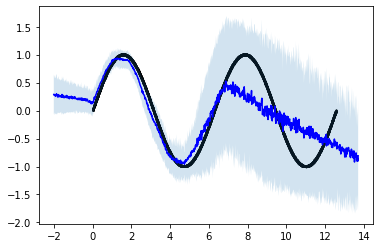

In [ ]:
# Predict
Nq = 1000
Xreg1q = np.linspace(0, 5*np.pi, Nq)[:,None] - 2
Yreg1q = regmodel1gm.predict(Xreg1q).sample(100) #ERR 2: sample
mean, sd = tf.reshape(np.mean(Yreg1q, axis=0),[-1]), tf.reshape(np.std(Yreg1q, axis=0),[-1])
print(Yreg1q.shape)
print("Xq-Yq shapes:", Xreg1q.shape, Yreg1q.shape) # ERR 1
print("Eval:", regmodel1gm.evaluate(Xreg1, Yreg1))
print("Eval_q:", regmodel1gm.evaluate(Xreg1q, mean)) 

pl.scatter(Xreg1, Yreg1, c='k', s=1)
pl.plot(Xreg1q, mean, c='b')
pl.fill_between(Xreg1q.squeeze(), mean - 2*sd, mean + 2*sd, alpha=0.2)

=================================================================

You could then train these guys normally: 

In [ ]:
regmodel = RegModel()
regmodel.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.MSE)
regmodel.fit(Xreg, Yreg)
print(regmodel.evaluate(Xreg[0:5], Yreg[0:5]))
print(regmodel.predict(Xreg[0:5]))


# classmodel = ClassModel()
# classmodel.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy())
# classmodel.fit(Xclass, Yclass)
# print(classmodel.evaluate(Xclass[0:5], Yclass[0:5]))
# print(classmodel.predict(Xclass[0:5]))

1/1 [==============================] - 0s 111ms/step - loss: 11276.7246
11276.724609375
[[2054.4988]
 [2145.9312]
 [2100.9233]
 [1964.1365]
 [2146.509 ]]


Alternatively, you could wrap them in an ensemble first 
(that second argument in the wrapper is the number of ensembles you'd like). 

The output will now be a mean and variance of ensemble outputs.

# NOTE: Fails with tf 2.1 No module named 'tensorflow.python.keras.layers.ops'" Needs to upgrade to >=2.2. Currently, testing using 2.4.1

In [ ]:
from WUT.Ensemble import Ensemble

regmodel = Ensemble(RegModel, 2)
regmodel.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.MSE)
regmodel.fit(Xreg, Yreg)
print(regmodel.evaluate(Xreg[0:5], Yreg[0:5]))
print(regmodel.predict(Xreg[0:5]))





# classmodel = Ensemble(ClassModel, 2)
# classmodel.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy())
# classmodel.fit(Xclass, Yclass)
# print(classmodel.evaluate(Xclass[0:5], Yclass[0:5]))
# print(classmodel.predict(Xclass[0:5]))




1/1 [==============================] - 0s 80ms/step - loss: 3633.9133
[2695.32958984375, 3633.913330078125]
tf.Tensor(
[[[2015.732    ]
  [   2.2370605]]

 [[2009.1104   ]
  [  28.44574  ]]

 [[2055.9775   ]
  [   6.4556885]]

 [[1996.7039   ]
  [  13.099243 ]]

 [[2107.6743   ]
  [   9.614868 ]]], shape=(5, 2, 1), dtype=float32)


Or, you could wrap them in an MC dropout scheme first 

(second arg is dropout rate, 

third arg defaults to what is below, and determines what types of layers dropout is applied to-- this hasn't been tested on everything, but Dense layers are definitely safe)

The output will now be a mean and variance of multiple trials through the network, with trials obviously determining trials.

In [ ]:
from WUT.Dropout import Dropout

regmodel = Dropout(RegModel, 0.2, dropout_layers = [tf.keras.layers.Dense])
regmodel.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.MSE)
regmodel.fit(Xreg, Yreg)
print(regmodel.evaluate(Xreg[0:5], Yreg[0:5]) )
print(regmodel.predict(Xreg[0:5], trials = 2))







classmodel = Dropout(ClassModel, 0.2)
classmodel.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy())
classmodel.fit(Xclass, Yclass)
print(classmodel.evaluate(Xclass[0:5], Yclass[0:5]))
print(classmodel.predict(Xclass[0:5], trials = 2) )






TypeError: function() got an unexpected keyword argument 'jit_compile'

Or, you could simply throw an additional network to predict error, as a regression

(extra args:

Std_Model: The model to predict variance. Defaults to a clone of input model, with activation on last layer removed)

error_activation: What to replace the activation on last layer with for the Std_Model. Defaults to None

one_hot: If true, will assume target values have already been converted to one_hot variables, and will not do it manually. Defaults to True.)


The output will now be simple predicted mean and variance.

In [ ]:
from WUT.Variance_Network import Variance_Network

regmodel = Variance_Network(RegModel)
regmodel.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.MSE)
regmodel.fit(Xreg, Yreg)
print(regmodel.evaluate(Xreg, Yreg)) 
print(regmodel.predict(Xreg[0:5]))






classmodel = Variance_Network(ClassModel)
classmodel.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy())
classmodel.fit(Xclass, Yclass)
print(classmodel.evaluate(Xclass, Yclass))
print(classmodel.predict(Xclass[0:5]))






TypeError: function() got an unexpected keyword argument 'jit_compile'

Or, you could fit a gaussian mixture model to this.
Second argument here is how many gaussians you'd like to fit.

Output is now a Probability distribution in posterior space


In [ ]:
from WUT.Gaussian_Mixtures import Gaussian_Mixtures

regmodel = Gaussian_Mixtures(RegModel, 5)
regmodel.compile(optimizer = tf.keras.optimizers.Adam())
regmodel.fit(Xreg, Yreg)
print(regmodel.evaluate(Xreg, Yreg)) 
regression_dist = regmodel.predict(Xreg[0:5])
print(regression_dist.sample())






classmodel = Gaussian_Mixtures(ClassModel, 5)
classmodel.compile(optimizer = tf.keras.optimizers.Adam())
classmodel.fit(Xclass[0:5], Yclass[0:5], epochs = 1000, verbose = False)
print(classmodel.evaluate(Xclass[0:5], Yclass[0:5]))
classification_dist = classmodel.predict(Xclass[0:5])
print(classification_dist.sample())


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
16105/16105 [==============================] - 11s 701us/step - loss: 6.2689
6.268917560577393
tf.Tensor(
[[1921.5614]
 [2114.6772]
 [2088.1204]
 [2074.249 ]
 [2280.48  ]], shape=(5, 1), dtype=float32)
1/1 [==============================] - 0s 990us/step - loss: 21114667008.0000
21114667008.0
tf.Tensor(
[[  -2.8682199   440.55505      -9.252266   -122.47605     285.3768
  -189.76274     -86.552826  ]
 [   0.63337547  485.99738    -286.06485    -224.61842    -326.705
    44.933136     -9.93264   ]
 [   1.9110353   292.4095      -83.9474        5.6412625   163.41637
   108.41966    -209.20148   ]
 [  -1.9658955   143.63368     -38.92147     -30.871521      7.049843
  -156.00131    -307.8017    ]
 [   2.242136   -328.57556    -191.11871      36.756676    164.90022
   137.1727      -38.892155  ]], shape=(5, 7), dtype=float32)


Lastly, if you've got a real masochistic streak, you could run Stochastic Variational Inference Here.

There are a lot of optional arguments here for those who want to get into the weeds, but I'll cover a few important ones:

task: set this to 'regression' or 'classification'. Defaults to regression.

one_hot: If True, assumes targets are one hot in classification case. Defaults True

normalize: whether to normalize inputs and outputs, defaults to True. If you encounter nans, try fiddling with this!

Returns: A probability distribution over the outputs pace



In [ ]:
from WUT.SVI import SVI

regmodel = SVI(RegModel)
regmodel.compile(optimizer = tf.keras.optimizers.Adam(lr=0.001))
regmodel.fit(Xreg, Yreg)
print(regmodel.evaluate(Xreg, Yreg)) 
regression_dist = regmodel.predict(Xreg[0:5])
print(regression_dist.sample())






classmodel = SVI(ClassModel, task = 'classification', one_hot = True)
classmodel.compile(optimizer = tf.keras.optimizers.Adam())
classmodel.fit(Xclass, Yclass)
print(classmodel.evaluate(Xclass, Yclass))
classification_dist = classmodel.predict(Xclass[0:5])
print(classification_dist.sample())



NameError: ignored